<a href="https://colab.research.google.com/github/ZaidAl2004/AER850_Project2/blob/main/AER_850_Project_2_Parts_1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1942 images belonging to 3 classes.
Found 431 images belonging to 3 classes.
{'crack': 0, 'missing-head': 1, 'paint-off': 2}
Image Batch Shape (32, 500, 500, 3)
Labels batch shape: (32, 3)


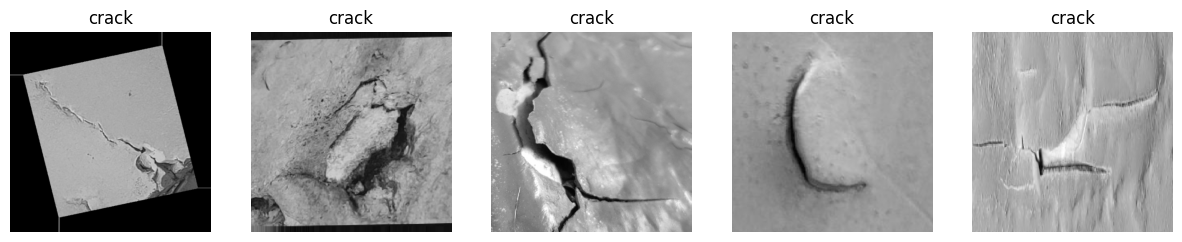

Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.5009453
Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.3660 - loss: 2.9617 - val_accuracy: 0.4988 - val_loss: 0.9656
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5428 - loss: 0.9851 - val_accuracy: 0.6241 - val_loss: 0.8237
Epoch 3/5
 1/61 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - accuracy: 0.5625 - loss: 0.8936

In [ ]:
# AER 850: Project 2 Parts 1-4
# By: Zaid Al-lababidi
# 501176747


# Initializing all relevent libraries
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras import layers
#Issue: can't import image data generator without including tensorflow. even
#even though keras was imported earlier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Did not end up utilizing this
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image


#Step 1: Data Processing
# Define all image dimemsions
image_height = 500
image_width = 500
channels = 3
#I need to ask as to why channels = 3 instead of 1 since it is gray-scaled.


#Define path to training, validation and testing data
from google.colab import drive
drive.mount('/content/drive')


train_dir = '/content/drive/MyDrive/project_2_data/Data/train'
val_dir   = '/content/drive/MyDrive/project_2_data/Data/valid'
test_dir  = '/content/drive/MyDrive/project_2_data/Data/test'


#Define an image data generator that is able to change and rescale data in a certain way
#The point of this function is to introduce variance into
train_datagen = ImageDataGenerator(
    rescale = 1./255, #Will make all pixel values in the range of 0-1
    shear_range = 0.2, #Will randomly slant the image by up to +-20%
    zoom_range = 0.2, #Will randomly zoom in to image by up to +-20%
    )


#Defining image data generator
val_datagen = ImageDataGenerator(rescale=1./255)


#Creating Data Generator for training and validation data
train_gen = train_datagen.flow_from_directory(
    train_dir, #calls the path to obtain data from
    target_size = (image_height, image_width), #defines size of each image
    batch_size = 32, #determines the batch size
    class_mode = "categorical", #makes sure that data is pretty much labelled
    color_mode='rgb', #This makes sure that the channels are 3 (which is weird since it's in grayscale)
    )


val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size = (image_height, image_width),
    batch_size = 32,
    class_mode = "categorical",
    color_mode='rgb',
    )


#Checking if data was saved properly
print(train_gen.class_indices)


images, labels = next(train_gen)
print("Image Batch Shape", images.shape)
print("Labels batch shape:", labels.shape)


#Plotting he first 5 images:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    class_name = list(train_gen.class_indices.keys())[label_index]
    plt.title(class_name)
    plt.axis('off')
plt.show()


#Verifying data has been normalized properly
print("Min pixel value:", np.min(images))
print("Max pixel value:", np.max(images))
print("Mean pixel value:", np.mean(images))


#Step 2: Neural Network Architecture Design
#Defining Input Shape
input_shape = (500, 500, 3)
#Initializing the model
#Ask TA if model optimization happens here or later when compiling?
#The following line was put in to solve an environment problem
from tensorflow.keras.models import Sequential


mdl = Sequential([
    #First Convulation Block -> Captures Simpler Features
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2,2)),

    #Second Convulation Block
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2,2)),

    #Third Convulation Block -> Capture More Complex Features
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Number of Filters: reasoning?
    # Kernel Size: reasoning?

    #Flatten the features to be inputted into neurons
    layers.Flatten(),

    #First Dense layer
    layers.Dense(256, activation='relu'), #Dense layer to learn all features
    layers.Dropout(0.5), #Regulize layers, reducing overfitting

    #Second Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    #Output Layer
    layers.Dense(3, activation='softmax') #3 neurons for each class type
    #Softmax is being used since its multi-class classification
    ])


#Step 3: Hyperparameter Tuning
mdl.compile(
    optimizer = 'adam', #Starting with adam
    loss = 'categorical_crossentropy', #Starting with categorical cross entropy
    metrics = ['accuracy'] #Metric should be changed based on what we need
    )


#Early stopping defined here, ensures model will stop once loss of accuracy is detected
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', #Monitor accuracy
    patience = 5, #number of epochs with no improvement before stopping
    restore_best_weights=True, #Will go back to previous run with better accuracy
    verbose=1 #Will print out a message mentioning early stopping
    )


#Defining batch size and epochs
BATCH_SIZE = 32
EPOCHS = 5


#Fitting the model to training data using validation data to evaluate
history = mdl.fit(
    train_gen,
    validation_data = val_gen,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stop],
    verbose=1
    )


#Creating the Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model 1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


#Creating the loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model 1 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#Saving the model to an external file on google drive
save_path = '/content/drive/MyDrive/model1.keras'
mdl.save(save_path)
print("Model was successfully saved to: ", save_path)


#Step 5 Evaluating Model Test Performance

#Loading the model saved
from tensorflow.keras.models import load_model
mdl = load_model("/content/drive/MyDrive/model1.keras")

#Defining Test Data Image Generator
test_datagen = ImageDataGenerator(rescale=1./255)


#Loading the Test Data
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size = (image_height, image_width),
    batch_size = 1, #Evaluate 1 image at a time
    class_mode = "categorical",
    color_mode='rgb',
    )


#Defining all the class labels
class_labels = list(test_gen.class_indices.keys())


#Visualize the predictions for targeted different images
target_filenames = ["crack/test_crack.jpg",
                    'missing-head/test_missinghead.jpg',
                    'paint-off/test_paintoff.jpg']


for img_path in target_filenames:

    img_full_path = os.path.join(test_dir, img_path)
    img = image.load_img(img_full_path, target_size=(500, 500))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    #Predict Probabilities
    preds = mdl.predict(img_array) #Predicts what the img should be
    pred_class = class_labels[np.argmax(preds)] #retrieve the class the model predicts

    index = test_gen.filenames.index(img_path) #Retrieves the index of the image
    true_label_index = test_gen.classes[index] #Retrieves the index of the true label
    true_label = class_labels[true_label_index] #Retrievs the actual true label

    #plot the image + display the probabilities
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"True Classification Label: {true_label}\n",
        f"Predicted Classification Label: {pred_class}",
        fontsize=10, loc='left', pad=10
        )

    text = '\n'.join([
        f"{cls.capitalize()}: {preds[j]*100:.1f}%" for j, cls in enumerate(class_labels)
        ])
    plt.text(10, 470, text, color='green', fontsize=10, weight='bold')
    plt.show()

#Again trying to commit code to thing

